In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,TensorDataset
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.Compose([ transforms.Resize((28,28)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean = [0.5], 
                                                      std = [0.5])])

training_dataset = datasets.MNIST(root = "./data", train = True, download = True, transform = transform)
validation_dataset = datasets.MNIST(root = "./data", train = False, download = True, transform = transform)

In [3]:
training_loader = DataLoader(dataset = training_dataset, batch_size = 100, shuffle = True)
validation_loader = DataLoader(dataset = validation_dataset, batch_size = 100, shuffle = False)

In [4]:
len(training_loader.dataset)

60000

In [5]:
def im_conv(tensor):

    image = tensor.clone().detach().numpy()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5)) + np.array((0.5))
    image = image.clip(0,1)

    return image

In [6]:
dataiter = iter(training_loader)
images, labels = next(dataiter)

In [7]:
images.max(),images.min()

(tensor(1.), tensor(-1.))

In [8]:
test = im_conv(images[0])
test.max(),test.min(),test.shape

(1.0, 0.0, (28, 28, 1))

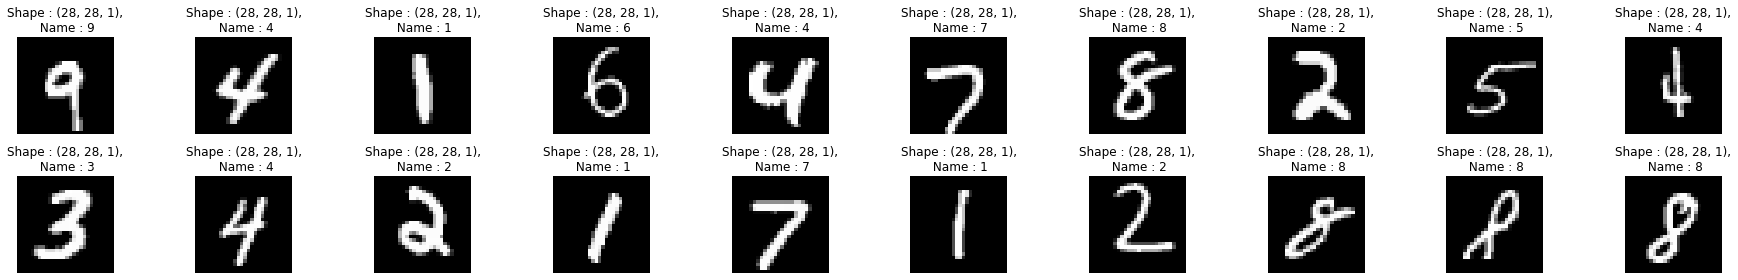

In [9]:
fig = plt.figure(figsize = (25,4))

for idx in np.arange(20):
    ax = fig.add_subplot(2,10,idx+1)
    convert_img = im_conv(images[idx])
    plt.imshow(convert_img.reshape(28,28), cmap = "gray")
    ax.set_title(f"Shape : {convert_img.shape},\n Name : {labels[idx].item()}")
    plt.axis("off")

plt.tight_layout()
plt.show()

----

In [10]:
class Classifier(nn.Module):

    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)

    def forward(self, x):
        
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

In [11]:
torch.manual_seed(101)
model = Classifier(D_in = 784, H1 = 125, H2 = 65, D_out = 10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr =0.01)

In [13]:
len(training_dataset),len(training_dataset) / 100,len(training_loader)

(60000, 600.0, 600)

In [14]:
len(validation_dataset),len(validation_loader) / 100,len(validation_loader)

(10000, 1.0, 100)

In [15]:
#import time

#start_time = time.time()
#epochs = 3
#max_trn_batch = 800 
#max_tst_batch = 300 
#train_losses = []
#test_losses = []
#train_correct = []
#test_correct = []

#for i in range(epochs):

#   trn_corr = 0
#   tst_corr = 0
#
#   for b, (X_train, y_train) in enumerate(train_loader):
#
#       if b == max_trn_batch:
#           break
#
#       b +=1
#
#       y_pred = CNNmodel(X_train)
#       loss = criterion(y_pred, y_train)
#
#
#       predicted = torch.max(y_pred, 1)[1]
#       batch_corr = (predicted == y_train).sum()
#       trn_corr +=batch_corr
#
#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()
#
#       if b % 200 == 0:
#               print(f'Epoch: {i:2} , Batch: {b:4} [{10*b:6}/8000] , Loss: {loss.item():10.8f} , Accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
#
#   train_losses.append(loss)
#   train_correct.append(trn_corr)
#
#
#   with torch.no_grad():
#
#       for b,(X_test, y_test) in enumerate(test_loader):
#
#           if b == max_tst_batch:
#               break
#
#           y_val = CNNmodel(X_test)
#
#           predicted = torch.max(y_val.data, 1)[1]
#           tst_corr +=(predicted == y_test).sum()
#

#    loss = criterion(y_val, y_test)
#    test_losses.append(loss)
#    test_correct.append(tst_corr)

#total_time = time.time() - start_time
#print()
#print(f"Total Time : {total_time / 60} Minutes...")

In [16]:
epochs = 12

train_losses = []
train_correct = []

test_losses = []
test_correct = []

for epoch in range(epochs):

    trn_loss = 0.0
    trn_corr = 0.0

    tst_loss = 0.0
    tst_corr = 0.0

    for b , (X_train, y_train) in enumerate(training_loader):

        b+=1
        inputs = X_train.view(X_train.shape[0],-1)
        outputs = model.forward(inputs)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = torch.max(outputs, 1)[1]
        trn_corr += (y_pred.data == y_train).sum()
        trn_loss +=loss.item()

        if b % 100 == 0:
            #print(f'Epoch: {i:2} , Batch: {b:4} [{10*b:6}/8000] , Loss: {loss.item():10.8f} , Accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
            print(f"Epoch : {epoch+1:3}, Batch : {b:3} [{b*100}/60000], Loss :{loss.item():4.4f}, Accuracy : {trn_corr*100/(b*100):.4f}%")

    else:
        with torch.no_grad():

            for X_test, y_test in validation_loader:
                
                val_inputs = X_test.view(X_test.shape[0], -1)
                val_outputs = model.forward(val_inputs)
                val_loss = criterion(val_outputs, y_test)
                val_pred=torch.max(val_outputs, 1)[1]
                
                tst_corr+=(val_pred == y_test).sum()
                tst_loss+=val_loss.item()

        # 1 tam epoch dönüşü değerler !!!
        
        train_loss = trn_loss/len(training_loader)
        train_corr = trn_corr.float() / len(training_loader)

        test_loss = tst_loss/len(validation_loader)
        test_corr = tst_corr.float() / len(validation_loader)

        train_losses.append(train_loss)
        train_correct.append(train_corr)

        test_losses.append(test_loss)
        test_correct.append(test_corr)

        print()
        print("".center(100,"-"))
        print()
        
        print(f"For Epoch : {epoch+1}")
        print("Training Loss : {:.4f}, Training Accuracy {:.4f}%".format(train_loss, train_corr.item()))
        print("Validation Loss : {:.4f}, Validation Accuracy {:.4f}%".format(test_loss, test_corr.item()))
        
        print()
        print("".center(100,"-"))
        print()


Epoch :   1, Batch : 100 [10000/60000], Loss :0.6154, Accuracy : 73.6100%
Epoch :   1, Batch : 200 [20000/60000], Loss :0.3064, Accuracy : 81.1550%
Epoch :   1, Batch : 300 [30000/60000], Loss :0.3778, Accuracy : 84.1933%
Epoch :   1, Batch : 400 [40000/60000], Loss :0.2841, Accuracy : 85.8700%
Epoch :   1, Batch : 500 [50000/60000], Loss :0.1437, Accuracy : 87.0740%
Epoch :   1, Batch : 600 [60000/60000], Loss :0.2350, Accuracy : 88.0383%

----------------------------------------------------------------------------------------------------

For Epoch : 1
Training Loss : 0.3886, Training Accuracy 88.0383%
Validation Loss : 0.2153, Validation Accuracy 93.5200%

----------------------------------------------------------------------------------------------------

Epoch :   2, Batch : 100 [10000/60000], Loss :0.2954, Accuracy : 92.3700%
Epoch :   2, Batch : 200 [20000/60000], Loss :0.1080, Accuracy : 92.5850%
Epoch :   2, Batch : 300 [30000/60000], Loss :0.1031, Accuracy : 92.9200%
Epoch : 

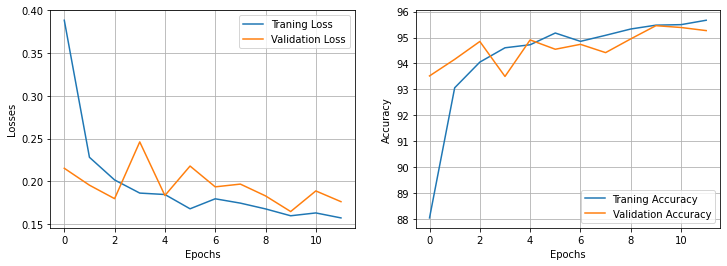

In [17]:
plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label = "Traning Loss")
plt.plot(test_losses, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend(loc = "best")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_correct, label = "Traning Accuracy")
plt.plot(test_correct, label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "best")
plt.grid(True)

plt.show()

In [18]:
url = "https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg"
url

'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'

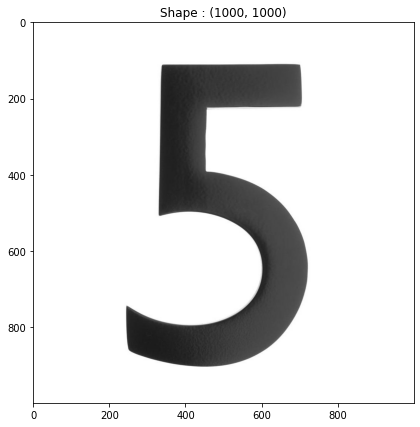

In [21]:
import requests
from PIL import Image
import cv2
import PIL

response = requests.get(url, stream = True)
img = Image.open(response.raw)

plt.figure(figsize = (7,7))
plt.imshow(img)
plt.title(f"Shape : {img.size}")
plt.show()

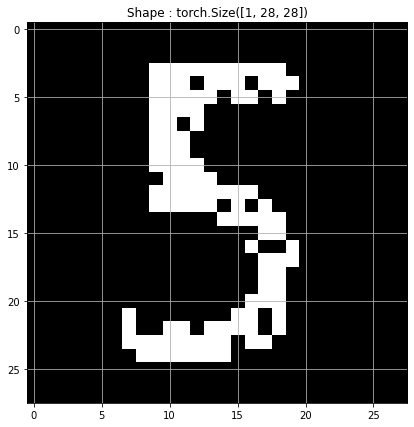

In [22]:
response = requests.get(url, stream = True)
img = Image.open(response.raw)
img = PIL.ImageOps.invert(img)
img = img.convert("1")
img = transform(img)

plt.figure(figsize = (7,7))
plt.imshow(im_conv(img).reshape(28,28), cmap = "gray")
plt.title(f"Shape : {img.shape}")
plt.grid(True)
plt.show()

In [23]:
with torch.no_grad():

    inputs = img.view(img.shape[0], -1)
    outputs = model(inputs)
    pred = torch.max(outputs, 1)[1]

print("Pred : ", pred.item() )

Pred :  5


In [24]:
dataiter = iter(validation_loader)
images, labels = next(dataiter)
images.shape, labels.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

In [25]:
def predictions(image):

    with torch.no_grad():

        inputs = image.view(image.shape[0], -1)
        outputs = model(inputs)
        pred = torch.max(outputs, 1)[1]

    return pred.item()

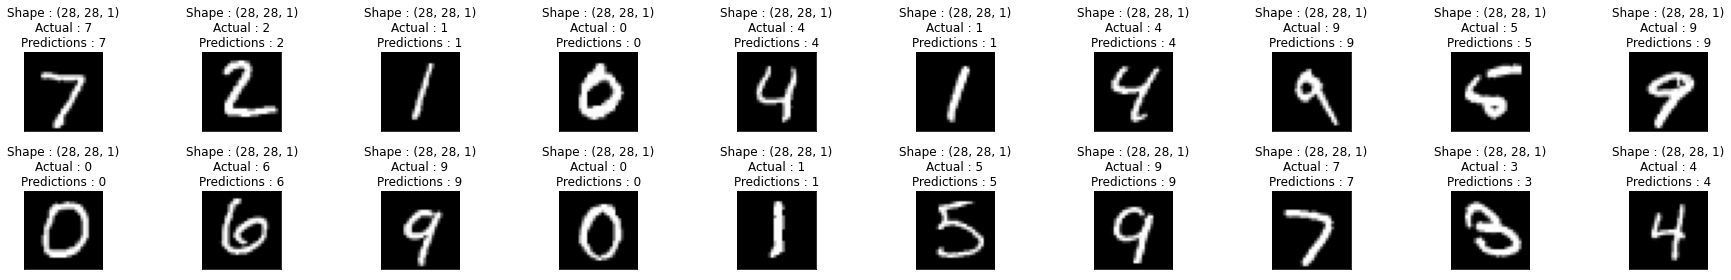

In [26]:
fig = plt.figure(figsize = (25,4))

for idx in np.arange(20):

    ax = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = [])
    convert = im_conv(images[idx])
    plt.imshow(convert.reshape((28,28)), cmap = "gray")

    pred = predictions(images[idx])
    ax.set_title(f"Shape : {convert.shape}\nActual : {labels[idx]}\nPredictions : {pred}")
 

plt.tight_layout()
plt.show()